In [1]:
import numpy as np
import os
from tensorflow import keras
from PIL import Image
import cv2
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from resizeimage import resizeimage
images=[]
labels=[]
def load_images_from_folder_a(folder,id):
    
    for filename in os.listdir(folder):
        if filename!="Thumbs.db":
            img1 = Image.open(os.path.join(folder,filename))
            new1 = resizeimage.resize_contain(img1, [40, 46, 3])
            new1 = np.array(new1, dtype='uint8')
            images.append(new1)
            if id==1:
                labels.append(1)
            else:
                labels.append(0)

load_images_from_folder_a("/users/sath/Documents/Projects/malaria-detection/cell_images/Parasitized",1)
load_images_from_folder_a("/users/sath/Documents/Projects/malaria-detection/cell_images/Uninfected/",2)

print(len(images))
print(len(labels))

27558
27558


In [4]:
cells = np.array(images)
cells = cells[...,:3] # png images have a fourth invisible layer so we select the first three to get RGB
cells = cells.astype('float32') / 255 
labels = labels

np.save( 'data/cells.npy' , cells )
np.save( 'data/labels.npy' , labels )

print('Cells : {} | labels : {}'.format(cells.shape , len(labels)))

Cells : (27558, 46, 40, 3) | labels : 27558


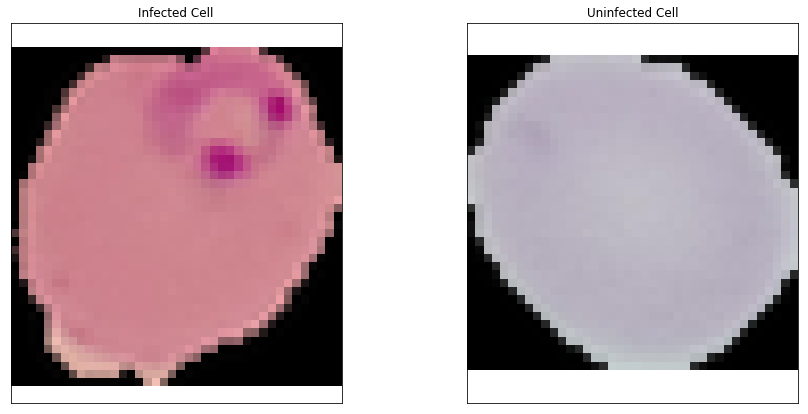

In [33]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[27557])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

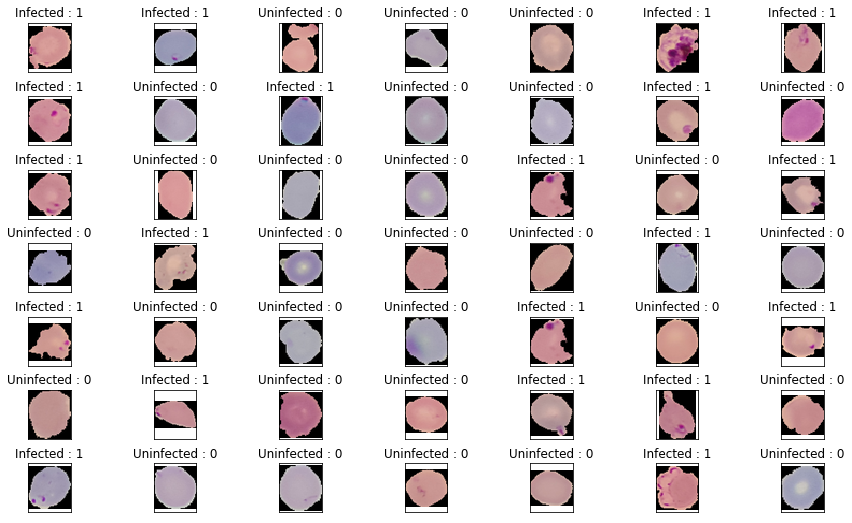

In [34]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Uninfected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(cells,labels,test_size=0.2,random_state=1)
print(len(X_train),len(X_test))
print(len(y_train),len(y_test))
print(X_train[100].shape)
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,2)
y_test=keras.utils.to_categorical(y_test,2)

22046 5512
22046 5512
(46, 40, 3)


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import SpatialDropout1D, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(46, 40, 3))) 
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
    
model.add(Dense(2, activation='softmax'))

model.summary() 

model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=["accuracy"])


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 40, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 10, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               983296    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________

In [7]:
model.fit(X_train,y_train, epochs=10, batch_size=52, shuffle=True, validation_data=(X_test,y_test))

Train on 22046 samples, validate on 5512 samples
Epoch 1/10
22046/22046 [==============================] - 65s 3ms/step - loss: 0.5536 - acc: 0.6961 - val_loss: 0.3643 - val_acc: 0.8452
Epoch 2/10
22046/22046 [==============================] - 65s 3ms/step - loss: 0.1922 - acc: 0.9322 - val_loss: 0.1691 - val_acc: 0.9425
Epoch 3/10
22046/22046 [==============================] - 70s 3ms/step - loss: 0.1468 - acc: 0.9520 - val_loss: 0.1606 - val_acc: 0.9490
Epoch 4/10
22046/22046 [==============================] - 71s 3ms/step - loss: 0.1319 - acc: 0.9572 - val_loss: 0.1501 - val_acc: 0.9516
Epoch 5/10
22046/22046 [==============================] - 71s 3ms/step - loss: 0.1211 - acc: 0.9594 - val_loss: 0.1617 - val_acc: 0.9516
Epoch 6/10
22046/22046 [==============================] - 69s 3ms/step - loss: 0.1124 - acc: 0.9622 - val_loss: 0.1584 - val_acc: 0.9534
Epoch 7/10
22046/22046 [==============================] - 70s 3ms/step - loss: 0.1041 - acc: 0.9653 - val_loss: 0.1492 - val_acc:

In [9]:
accuracy = model.evaluate(X_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

5512/5512 [==============================] - 5s 939us/step

 Test_Accuracy:- 0.9517416545718432


In [23]:
from sklearn.metrics import confusion_matrix, classification_report

# predict probabilities for test set
y_pred = model.predict(X_test, verbose=0)
# predict crisp classes for test set
classes = model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2665
           1       0.97      0.94      0.95      2847

   micro avg       0.95      0.95      0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512
 samples avg       0.95      0.95      0.95      5512



In [24]:
# Function to plot confusion matrix

import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=15)
    plt.yticks(tick_marks, classes, rotation=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    
        #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix undersampled


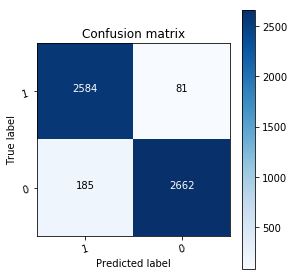

In [30]:
# Plot confusion matrix for model and associated classification report
y_pred = model.predict(X_test, verbose=0)
class_set = [1, 0]
cnf_matrix_und = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
print ("Confusion matrix undersampled")
plt.rcParams['figure.figsize']=(4,4)
plot_confusion_matrix(cm=cnf_matrix_und, classes=class_set)
plt.show()

In [32]:
from keras.models import load_model
model.save('/users/sath/Documents/Projects/malaria-detection/models/cells_cnn.h5')